In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchlet.engine import Value
from torchlet.nn import Linear, ReLU, Sequential

In [3]:
np.random.seed(1337)
random.seed(1337)

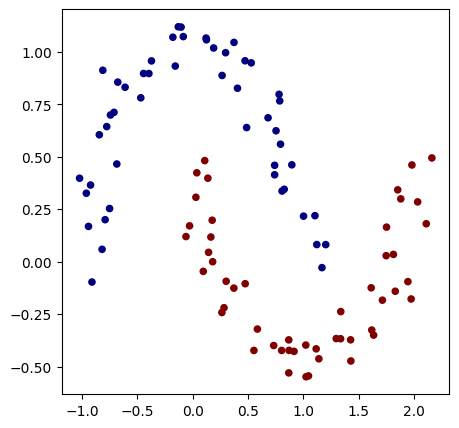

In [4]:
# Make up  a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [5]:
# Define a model
in_dim = 2
hidden_dim = 16
out_dim = 1

model = Sequential(
    Linear(in_dim, hidden_dim),
    ReLU(),
    Linear(hidden_dim, hidden_dim),
    ReLU(),
    Linear(hidden_dim, out_dim),
)
print(model)
print("number of parameters", sum(v.data.size for v in model.parameters()))

Sequential(Linear(2, 16), ReLU(), Linear(16, 16), ReLU(), Linear(16, 1))
number of parameters 337


In [6]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = list(map(Value, Xb))

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4

    reg_loss = alpha * sum((p**2).sum() for p in model.parameters())
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


Value(data=[[1.58106339]], grad=[[0.]]) [[0.48]]


In [7]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    # learning_rate = 1.0
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss [[1.58106339]], accuracy [[48.]]%
step 1 loss [[1.38485779]], accuracy [[68.]]%
step 2 loss [[0.93471567]], accuracy [[74.]]%
step 3 loss [[0.72704393]], accuracy [[78.]]%
step 4 loss [[0.38479063]], accuracy [[84.]]%
step 5 loss [[0.34811404]], accuracy [[85.]]%
step 6 loss [[0.26926578]], accuracy [[88.]]%
step 7 loss [[0.22378791]], accuracy [[91.]]%
step 8 loss [[0.18317625]], accuracy [[92.]]%
step 9 loss [[0.18314398]], accuracy [[94.]]%
step 10 loss [[0.23431048]], accuracy [[91.]]%
step 11 loss [[0.25095461]], accuracy [[90.]]%
step 12 loss [[0.18970387]], accuracy [[93.]]%
step 13 loss [[0.13919248]], accuracy [[95.]]%
step 14 loss [[0.14198196]], accuracy [[94.]]%
step 15 loss [[0.15969667]], accuracy [[98.]]%
step 16 loss [[0.44763846]], accuracy [[84.]]%
step 17 loss [[0.1964421]], accuracy [[92.]]%
step 18 loss [[0.1245467]], accuracy [[96.]]%
step 19 loss [[0.13935248]], accuracy [[92.]]%
step 20 loss [[0.10803758]], accuracy [[99.]]%
step 21 loss [[0.13952833

(-1.548639298268643, 1.951360701731357)

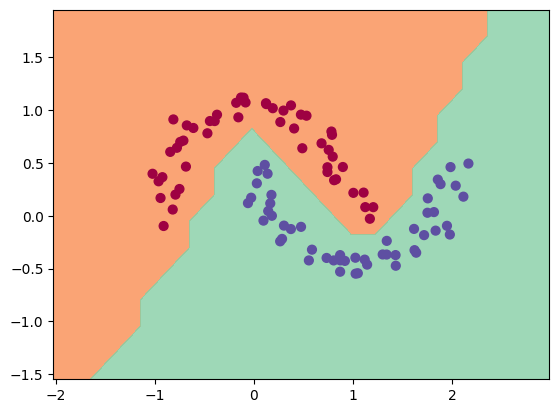

In [10]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = list(map(Value, Xmesh))
scores = np.array(list(map(model, inputs)))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())